## Importación del dataset y preprocesado

In [48]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2, SelectKBest
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import warnings
warnings.filterwarnings("ignore")

### Introducción
En este notebook, realizaremos un análisis de **reducción de características**, que abarca tanto la **selección** como la **extracción de características**, aplicados a un conjunto de datos de canciones de Spotify. La **selección de características** busca identificar un subconjunto de las características más relevantes de los datos, mientras que la **extracción de características** transforma las características originales en un nuevo conjunto de características que preserva la información esencial. El objetivo de este análisis es simplificar la representación de los datos, reduciendo su número de dimensiones sin perder información clave. Este proceso puede mejorar tanto la eficiencia computacional como la interpretación de los modelos de análisis, facilitando la identificación de patrones y relaciones subyacentes en los datos.


A lo largo de este notebook, exploraremos diferentes técnicas de reducción de dimensionalidad y extracción de características para encontrar la mejor forma de representar los datos de las canciones de Spotify.

**Explicación de las varibables:**
- track: Nombre de la canción.
- artist: Artista de la canción.
- uri: Identificador de recurso de la canción.
- danceability: Qué tan bailable es la canción (0.0 a 1.0).
- energy: Medida de intensidad y actividad de la canción.
- key: Tono de la canción.
- loudness: Nivel de volumen promedio.
- mode: Modalidad de la canción (0 = menor, 1 = mayor).
- speechiness: Medida de palabras habladas en la pista.
- acousticness: Confianza de que la canción sea acústica.
- instrumentalness: Si la canción tiene voz o no.
- liveness: Presencia de audiencia en la grabación.
- valence: Positividad transmitida por la canción.
- tempo: Velocidad de la canción en BPM.
- duration_ms: Duración de la pista en milisegundos.
- chorus_hit: Mejor estimación del inicio del estribillo.
- sections: Número de secciones en la canción.
- target: ['Underground Rap', 'techhouse', 'Trap Metal', 'techno', 'Hiphop', 'Pop', 'RnB', 'trance', 'psytrance', 'trap', 'Rap', 'Dark Trap', 'dnb', 'Emo', 'hardstyle']

In [4]:
data = pd.read_csv('data/train.csv')
# son identificadores e información para la API que no da información útil sobre la canción
data.drop('id', axis = 1, inplace= True)
data.drop('type', axis = 1, inplace= True)
data.drop('uri', axis = 1, inplace= True)
data.drop('track_href', axis = 1, inplace= True)
data.drop('analysis_url', axis = 1, inplace= True)

## Unnamed: 0 parece que se genera cuando el registro no tienen un nombre de canción, hay muchas vacias y no parece tener relación directa con la canción 
## Id es un identificador de la BBDD, podemos borralo
data.drop('Unnamed: 0', axis = 1, inplace= True)
data.drop('Id', axis = 1, inplace= True)

## por el momento, borramos las columnas de title y song name: 
data.drop('song_name', axis = 1, inplace= True)
data.drop('title', axis = 1, inplace= True)

## menos importante
## data.drop('mode', axis = 1, inplace= True)
## data.drop('time_signature', axis = 1, inplace= True)


percentile_95_Danceability = data['danceability'].quantile(0.95)
percentile_5_Danceability = data['danceability'].quantile(0.05)

percentile_95_energy = data['energy'].quantile(0.95)
percentile_5_energy = data['energy'].quantile(0.05)

percentile_95_loudness = data['loudness'].quantile(0.95)
percentile_5_loudness = data['loudness'].quantile(0.05)

percentile_95_speechiness = data['speechiness'].quantile(0.95)
percentile_5_speechiness = data['speechiness'].quantile(0.05)

percentile_95_tempo = data['tempo'].quantile(0.95)
percentile_5_tempo = data['tempo'].quantile(0.05)

percentile_95_liveness = data['liveness'].quantile(0.95)
percentile_5_liveness = data['liveness'].quantile(0.05)

percentile_95_acousticness = data['acousticness'].quantile(0.95)
percentile_5_acousticness = data['acousticness'].quantile(0.05)

percentile_95_duration_ms = data['duration_ms'].quantile(0.95)
percentile_5_duration_ms = data['duration_ms'].quantile(0.05)

data['duration_ms'] = data['duration_ms'].clip(lower=percentile_5_duration_ms, upper=percentile_95_duration_ms)

data['acousticness'] = data['acousticness'].clip(lower=percentile_5_acousticness, upper=percentile_95_acousticness)

data['liveness'] = data['liveness'].clip(lower=percentile_5_liveness, upper=percentile_95_liveness)

data['tempo'] = data['tempo'].clip(lower=percentile_5_tempo, upper=percentile_95_tempo)

data['speechiness'] = data['speechiness'].clip(lower=percentile_5_speechiness, upper=percentile_95_speechiness)

data['loudness'] = data['loudness'].clip(lower=percentile_5_loudness, upper=percentile_95_loudness)

data['energy'] = data['energy'].clip(lower=percentile_5_energy, upper=percentile_95_energy)

data['danceability'] = data['danceability'].clip(lower=percentile_5_Danceability, upper=percentile_95_Danceability)

# Initialize the scaler
scaler = MinMaxScaler()

# Select all columns except 'label' for scaling
data_to_scale = data.drop(columns=['genre'])

# Fit and transform the data (scaling)
scaled_data = scaler.fit_transform(data_to_scale)

# Convert the scaled data back into a DataFrame with the same column names (excluding 'label')
data_scaled = pd.DataFrame(scaled_data, columns=data_to_scale.columns)

# Add the 'label' column back to the scaled data
data_train = pd.concat([data_scaled, data[['genre']]], axis=1)

# Display the first few rows of the scaled data
print(data_train.head())


   danceability    energy       key  loudness  mode  speechiness  \
0      1.000000  0.476619  0.090909  0.438318   1.0     0.920132   
1      0.108216  0.964029  0.181818  0.602469   1.0     0.261911   
2      0.617234  0.478417  0.000000  0.629775   0.0     0.793445   
3      0.126253  0.836331  0.636364  0.912254   0.0     0.005784   
4      0.000000  0.809353  0.363636  0.930876   0.0     0.182044   

   acousticness  instrumentalness  liveness   valence     tempo  duration_ms  \
0      0.023764          0.000000  0.048154  0.666770  0.966435     0.091822   
1      0.003733          0.163802  1.000000  0.108635  0.294429     0.289260   
2      0.977981          0.000000  0.192081  0.650263  0.757850     0.438098   
3      0.035737          0.824065  0.218834  0.017126  0.773746     0.587594   
4      0.069831          0.000000  0.113608  0.238626  1.000000     0.299199   

   time_signature            genre  
0            0.75  Underground Rap  
1            0.75           trance  

In [5]:
X = data_train.drop('genre', axis= 1)
y = data_train['genre']

In [6]:
# Mapeo personalizado
genre_mapping = {
    'Dark Trap': 0,
    'Underground Rap': 1,
    'Trap Metal': 2,
    'Emo': 3,
    'Rap': 4,
    'RnB': 5,
    'Pop': 6,
    'Hiphop': 7,
    'techhouse': 8,
    'techno': 9,
    'trance': 10,
    'psytrance': 11,
    'trap': 12,
    'dnb': 13,
    'hardstyle': 14
}

# Aplicar el mapeo a la columna 'target'
y_encoded = y.map(genre_mapping)


### Modelo Base

Para evaluar el impacto de cada experimento, compararemos los resultados con un modelo previamente ajustado y optimizado.
El modelo utilizado es un **RandomForestClassifier** con los siguientes parámetros: 
`n_estimators=150`, `max_depth=None`, `min_samples_split=5`, `random_state=42`, `class_weight='balanced'`, y `n_jobs=-1`. Este modelo ha sido previamente optimizado y ajustado, y los resultados de validación cruzada obtenidos son los siguientes:

- Puntuaciones de validación cruzada: [0.6571, 0.6587, 0.6528, 0.6531, 0.6585]
- Precisión media: 0.6561
- Desviación estándar: 0.0026

Con estos resultados como referencia, en los experimentos posteriores se aplicarán técnicas de **reducción de dimensionalidad** y se realizará un **nuevo proceso de validación cruzada** con cada técnica. El objetivo es observar si la reducción de dimensionalidad mejora, empeora o no afecta significativamente al rendimiento del modelo en comparación con el modelo base.


In [31]:
rf = RandomForestClassifier(n_estimators= 150, max_depth=None, min_samples_split=5, random_state=42, class_weight='balanced', n_jobs=-1)

In [139]:
# Calcular el cross-validation score
cv_scores = cross_val_score(rf, X, y_encoded, cv=5, scoring='accuracy')  # 5 particiones, métrica: precisión

# Mostrar los resultados
print("Puntuaciones de validación cruzada:", cv_scores)
print("Precisión media:", cv_scores.mean())
print("Desviación estándar:", cv_scores.std())

Puntuaciones de validación cruzada: [0.65711331 0.65873837 0.65282907 0.65312454 0.65854019]
Precisión media: 0.6560690955883919
Desviación estándar: 0.002588043759912342


## Métodos de filtro - Feature Selection

### Umbral de Varianza

Una de las técnicas de reducción de dimensionalidad utilizadas en este análisis es el **Umbral de Varianza**. Esta técnica se basa en la idea de que las características con baja varianza contienen poca información útil para el modelo, por lo que se pueden eliminar sin afectar significativamente el rendimiento. En otras palabras, aquellas características que no varían lo suficiente entre las muestras son descartadas, ya que no aportan valor para la diferenciación de los datos. Este enfoque permite reducir el número de dimensiones de los datos, manteniendo aquellas que contienen la mayor parte de la información relevante.


In [125]:
# Aplicar umbral de varianza
selector = VarianceThreshold(threshold=0.05)
data_reduced = selector.fit_transform(X)

# Verificar resultados
print("Forma original:", data_scaled.shape)
print("Forma reducida:", data_reduced.shape)
print("Columnas seleccionadas:", selector.get_support(indices=True))

Forma original: (33844, 13)
Forma reducida: (33844, 12)
Columnas seleccionadas: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [127]:
# Aplicar umbral de varianza (asumiendo que X es tu DataFrame original)
selector = VarianceThreshold(threshold=0.05)
data_reduced = selector.fit_transform(X)

# Convertir el resultado a DataFrame manteniendo nombres de columnas
selected_columns_indices = selector.get_support(indices=True)
selected_columns = X.columns[selected_columns_indices]
df_reduced = pd.DataFrame(data_reduced, columns=selected_columns)

# Obtener columnas eliminadas
eliminated_columns = X.columns[~selector.get_support()].tolist()

# Verificar resultados
print("\nForma original:", X.shape)
print("Forma reducida:", df_reduced.shape)
print("\nColumnas conservadas:", df_reduced.columns.tolist())
print("\nColumnas eliminadas:", eliminated_columns)

# Mostrar DataFrame reducido
print("\nDataFrame reducido:")
print(df_reduced.head())


Forma original: (33844, 13)
Forma reducida: (33844, 12)

Columnas conservadas: ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

Columnas eliminadas: ['time_signature']

DataFrame reducido:
   danceability    energy       key  loudness  mode  speechiness  \
0      1.000000  0.476619  0.090909  0.438318   1.0     0.920132   
1      0.108216  0.964029  0.181818  0.602469   1.0     0.261911   
2      0.617234  0.478417  0.000000  0.629775   0.0     0.793445   
3      0.126253  0.836331  0.636364  0.912254   0.0     0.005784   
4      0.000000  0.809353  0.363636  0.930876   0.0     0.182044   

   acousticness  instrumentalness  liveness   valence     tempo  duration_ms  
0      0.023764          0.000000  0.048154  0.666770  0.966435     0.091822  
1      0.003733          0.163802  1.000000  0.108635  0.294429     0.289260  
2      0.977981          0.000000  0.192081  0.650263  0.757

In [140]:
# Calcular el cross-validation score
cv_scores = cross_val_score(rf, df_reduced, y_encoded, cv=5, scoring='accuracy')  # 5 particiones, métrica: precisión

# Mostrar los resultados
print("Puntuaciones de validación cruzada:", cv_scores)
print("Precisión media:", cv_scores.mean())
print("Desviación estándar:", cv_scores.std())

Puntuaciones de validación cruzada: [0.65696558 0.66051115 0.64765844 0.65282907 0.65868794]
Precisión media: 0.655330438408724
Desviación estándar: 0.004602231497311235


Eliminamos la columna time_signature y mejora ligeramente el modelo

### Eliminación por Correlación

Otra técnica empleada para la reducción de dimensionalidad es la **eliminación de características altamente correlacionadas**. Cuando dos o más variables están altamente correlacionadas entre sí, significa que contienen información redundante. En estos casos, se puede conservar solo una de ellas sin perder valor informativo, lo que permite simplificar el conjunto de datos y reducir su complejidad. Esta técnica ayuda a evitar problemas como la multicolinealidad y puede mejorar la eficiencia y la interpretabilidad del modelo, manteniendo solo las variables más representativas.

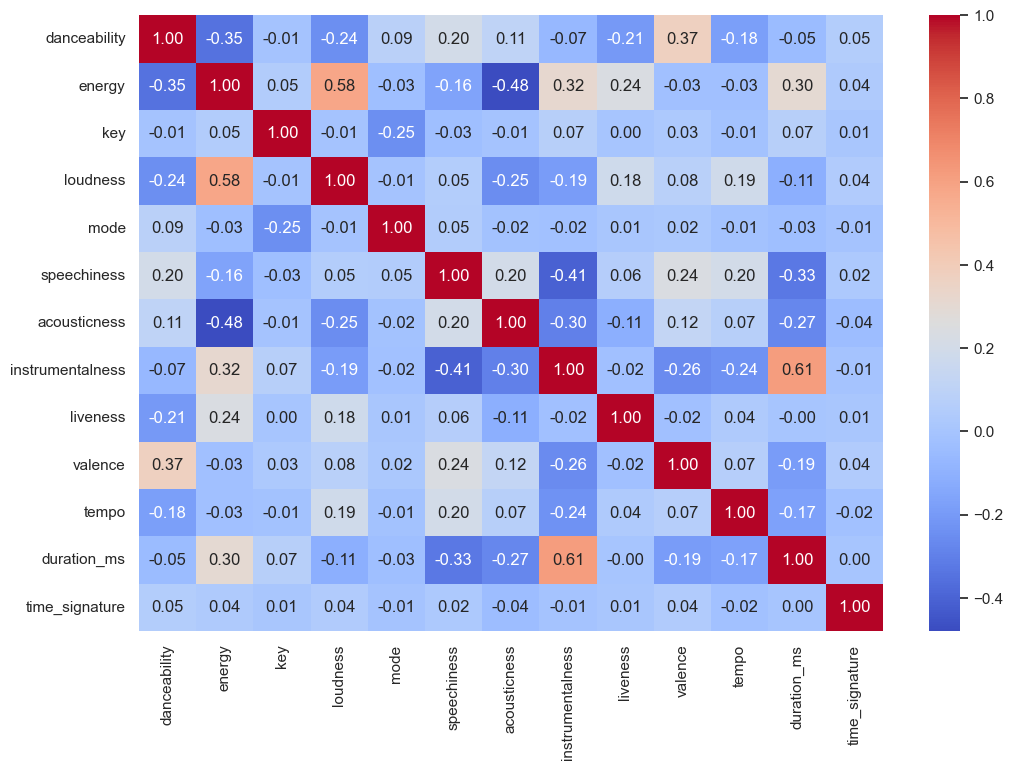

In [128]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Puedes cambiar (12, 8) al tamaño que prefieras

# Crear el heatmap
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt=".2f")

# Mostrar el gráfico
plt.show()

Ningún par de variables muestra una correlación lo suficientemente alta como para justificar la eliminación de alguna de ellas por redundancia. La correlación más elevada observada en el análisis es de -0.48, un valor que, si bien indica cierta relación entre las variables, no es lo bastante fuerte como para considerarlo problemático o redundante.

### Selección de características con Chi-cuadrado

La prueba de **Chi-cuadrado** es una técnica de selección de características utilizada principalmente cuando se trabaja con variables categóricas. Esta técnica evalúa la independencia entre cada característica y la variable objetivo, midiendo si existe una relación estadísticamente significativa entre ellas. Cuanto mayor sea el valor de chi-cuadrado, mayor será la dependencia entre la característica y la clase, y por tanto, mayor su relevancia. De este modo, se seleccionan las variables que tienen mayor poder explicativo respecto al objetivo del modelo, reduciendo el conjunto de características a las más informativas.

In [152]:
# Seleccionar las k mejores características
k = 7  # Número de características a seleccionar
selector = SelectKBest(chi2, k=k)
X_new = selector.fit_transform(X, y)

# Obtener las características seleccionadas
selected_features = selector.get_support(indices=True)
print("Características seleccionadas:", data_scaled.columns[selected_features])

Características seleccionadas: Index(['danceability', 'energy', 'speechiness', 'acousticness',
       'instrumentalness', 'tempo', 'duration_ms'],
      dtype='object')


In [153]:
# Obtener las puntuaciones Chi-cuadrado
chi_scores = selector.scores_
print("Puntuaciones Chi-cuadrado:", chi_scores)

Puntuaciones Chi-cuadrado: [2.18679104e+03 2.21226967e+03 7.59601209e+01 1.55482370e+03
 4.46710981e+02 3.59551971e+03 3.51352409e+03 9.61996843e+03
 8.14420924e+02 1.50113631e+03 2.13996155e+03 4.48321935e+03
 7.49557594e-01]


In [154]:
# Crear un DataFrame con las características seleccionadas
df_selected = data_scaled.iloc[:, selected_features]

# Mostrar el nuevo DataFrame
print("\nDataFrame con características seleccionadas:")
print(df_selected)


DataFrame con características seleccionadas:
       danceability    energy  speechiness  acousticness  instrumentalness  \
0          1.000000  0.476619     0.920132      0.023764          0.000000   
1          0.108216  0.964029     0.261911      0.003733          0.163802   
2          0.617234  0.478417     0.793445      0.977981          0.000000   
3          0.126253  0.836331     0.005784      0.035737          0.824065   
4          0.000000  0.809353     0.182044      0.069831          0.000000   
...             ...       ...          ...           ...               ...   
33839      0.955912  0.287770     0.363812      0.405694          0.000000   
33840      0.765531  0.539568     0.083448      0.116709          0.000000   
33841      0.172345  0.741007     0.014321      0.000123          0.764408   
33842      0.611222  0.294964     0.892592      0.436135          0.000000   
33843      0.981964  0.410072     0.114844      0.421929          0.000000   

          tempo  

In [155]:
# Calcular el cross-validation score
cv_scores = cross_val_score(rf, df_selected, y_encoded, cv=5, scoring='accuracy')  # 5 particiones, métrica: precisión

# Mostrar los resultados
print("Puntuaciones de validación cruzada:", cv_scores)
print("Precisión media:", cv_scores.mean())
print("Desviación estándar:", cv_scores.std())

Puntuaciones de validación cruzada: [0.63480573 0.64485153 0.63229428 0.62978283 0.63903664]
Precisión media: 0.6361542040668644
Desviación estándar: 0.005315329680487351


Con tan solo 7 características seleccionadas mediante el test de Chi-cuadrado se alcanza una precisión del 63%, apenas un 2% menos que el modelo original, a pesar de haber reducido el número de variables en 5. Esto indica que es posible simplificar considerablemente el conjunto de datos sin comprometer significativamente el rendimiento del modelo.

## Wrapping Methods - Feature Selection

### Selección Secuencial de Características (SFS)

Otra técnica aplicada en este análisis es la **Selección Secuencial de Características**. Este método busca identificar el subconjunto óptimo de características para mejorar el rendimiento del modelo, mediante un enfoque iterativo.

Se han utilizado dos variantes:

- **SFS Forward (hacia adelante)**: comienza con un conjunto vacío de características e incorpora, en cada iteración, la que más mejora el rendimiento del modelo, hasta alcanzar un número predefinido o un criterio de parada.
  
- **SFS Backward (hacia atrás)**: parte del conjunto completo de características y elimina, en cada paso, la menos relevante, es decir, la que menor impacto tiene sobre el rendimiento global del modelo.

Este tipo de selección tiene la ventaja de considerar las interacciones entre variables y su efecto combinado sobre el modelo, ofreciendo un enfoque más exhaustivo que métodos basados únicamente en métricas individuales.

In [134]:
rf = RandomForestClassifier(n_estimators= 150, max_depth=None, min_samples_split=5, random_state=42, class_weight='balanced', n_jobs=-1)

#### Forward

In [135]:
# Configuración del selector de características
sfs = SFS(
    rf, 
    k_features='best', 
    forward=True, 
    floating=False, 
    scoring='f1_micro', 
    cv=2
)

# Ajustar el selector a los datos
sfs.fit(X, y_encoded)

SequentialFeatureSelector(cv=2,
                          estimator=RandomForestClassifier(class_weight='balanced',
                                                           min_samples_split=5,
                                                           n_estimators=150,
                                                           n_jobs=-1,
                                                           random_state=42),
                          k_features=(1, 13), scoring='f1_micro')

In [136]:
# Obtener los índices de las características seleccionadas
selected_feature_indices = sfs.k_feature_idx_

# Obtener los nombres de las características seleccionadas (si X es un DataFrame)
selected_feature_names = list(sfs.k_feature_names_)

print("Índices de características seleccionadas:", selected_feature_indices)
print("Nombres de características seleccionadas:", selected_feature_names)

Índices de características seleccionadas: (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11)
Nombres de características seleccionadas: ['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']


In [156]:
# Crear un nuevo DataFrame con las características seleccionadas
df_selected = X[selected_feature_names]

# Mostrar el nuevo DataFrame
print("DataFrame con características seleccionadas:")
print(df_selected)

DataFrame con características seleccionadas:
       danceability    energy       key  loudness  speechiness  acousticness  \
0          1.000000  0.476619  0.090909  0.438318     0.920132      0.023764   
1          0.108216  0.964029  0.181818  0.602469     0.261911      0.003733   
2          0.617234  0.478417  0.000000  0.629775     0.793445      0.977981   
3          0.126253  0.836331  0.636364  0.912254     0.005784      0.035737   
4          0.000000  0.809353  0.363636  0.930876     0.182044      0.069831   
...             ...       ...       ...       ...          ...           ...   
33839      0.955912  0.287770  0.545455  0.466461     0.363812      0.405694   
33840      0.765531  0.539568  0.000000  0.718390     0.083448      0.116709   
33841      0.172345  0.741007  0.727273  0.505380     0.014321      0.000123   
33842      0.611222  0.294964  0.000000  0.695059     0.892592      0.436135   
33843      0.981964  0.410072  0.818182  0.707300     0.114844      0.42192

In [157]:
# Calcular el cross-validation score
cv_scores = cross_val_score(rf, df_selected, y_encoded, cv=5, scoring='accuracy')  # 5 particiones, métrica: precisión

# Mostrar los resultados
print("Puntuaciones de validación cruzada:", cv_scores)
print("Precisión media:", cv_scores.mean())
print("Desviación estándar:", cv_scores.std())

Puntuaciones de validación cruzada: [0.6543064  0.65859063 0.64898803 0.65356774 0.65750591]
Precisión media: 0.6545917419385483
Desviación estándar: 0.0033768349108048777


Eliminando una colunas, mejoramos la precisión del modelo base

#### Backward

In [159]:
# Configuración del selector de características
sfs = SFS(
    rf, 
    k_features='best', 
    forward=False, 
    floating=True, 
    scoring='f1_micro', 
    cv=2
)

# Ajustar el selector a los datos
sfs.fit(X, y_encoded)

SequentialFeatureSelector(cv=2,
                          estimator=RandomForestClassifier(class_weight='balanced',
                                                           min_samples_split=5,
                                                           n_estimators=150,
                                                           n_jobs=-1,
                                                           random_state=42),
                          floating=True, forward=False, k_features=(1, 13),
                          scoring='f1_micro')

In [160]:
# Obtener los índices de las características seleccionadas
selected_feature_indices = sfs.k_feature_idx_

# Obtener los nombres de las características seleccionadas (si X es un DataFrame)
selected_feature_names = list(sfs.k_feature_names_)

print("Índices de características seleccionadas:", selected_feature_indices)
print("Nombres de características seleccionadas:", selected_feature_names)

Índices de características seleccionadas: (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)
Nombres de características seleccionadas: ['danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']


In [161]:
# Crear un nuevo DataFrame con las características seleccionadas
df_selected = X[selected_feature_names]

# Mostrar el nuevo DataFrame
print("DataFrame con características seleccionadas:")
print(df_selected)

DataFrame con características seleccionadas:
       danceability    energy  loudness  mode  speechiness  acousticness  \
0          1.000000  0.476619  0.438318   1.0     0.920132      0.023764   
1          0.108216  0.964029  0.602469   1.0     0.261911      0.003733   
2          0.617234  0.478417  0.629775   0.0     0.793445      0.977981   
3          0.126253  0.836331  0.912254   0.0     0.005784      0.035737   
4          0.000000  0.809353  0.930876   0.0     0.182044      0.069831   
...             ...       ...       ...   ...          ...           ...   
33839      0.955912  0.287770  0.466461   1.0     0.363812      0.405694   
33840      0.765531  0.539568  0.718390   1.0     0.083448      0.116709   
33841      0.172345  0.741007  0.505380   1.0     0.014321      0.000123   
33842      0.611222  0.294964  0.695059   1.0     0.892592      0.436135   
33843      0.981964  0.410072  0.707300   0.0     0.114844      0.421929   

       instrumentalness  liveness   valenc

In [162]:
# Calcular el cross-validation score
cv_scores = cross_val_score(rf, df_selected, y_encoded, cv=5, scoring='accuracy')  # 5 particiones, métrica: precisión

# Mostrar los resultados
print("Puntuaciones de validación cruzada:", cv_scores)
print("Precisión media:", cv_scores.mean())
print("Desviación estándar:", cv_scores.std())

Puntuaciones de validación cruzada: [0.65607918 0.65962476 0.65312454 0.65489733 0.65824468]
Precisión media: 0.6563940979370911
Desviación estándar: 0.0023191097691087747


El método de backward ha eliminado una característica y ha mejorado el rendimiento ligeramente

## Embedded Methods - Feature Selection

### Selección de características con Lasso

También se ha aplicado **Lasso (Least Absolute Shrinkage and Selection Operator)** como método de selección de características. Lasso es una técnica de regularización que, además de reducir el sobreajuste, permite realizar una selección automática de variables. Lo hace penalizando los coeficientes de las características menos relevantes, forzando algunos de ellos a ser exactamente cero. De este modo, se eliminan automáticamente aquellas variables que tienen poca o nula influencia en el modelo, simplificando su estructura sin comprometer el rendimiento. Esta técnica es especialmente útil cuando se trabaja con conjuntos de datos con muchas variables, ya que ayuda a identificar las más significativas de forma eficiente.

In [172]:
for C_value in [1.0, 0.1, 0.01]:
    Lr = LogisticRegression(penalty='l1', solver='liblinear', C=C_value, random_state=42)
    Lr.fit(X, y)
    coefficients = Lr.coef_[0]
    print(f"\nCoeficientes para C={C_value}:")
    print(pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients}))


Coeficientes para C=1.0:
             Feature  Coefficient
0       danceability    -0.675492
1             energy    -1.364465
2                key     0.076038
3           loudness    -0.843791
4               mode    -0.092726
5        speechiness    -0.632804
6       acousticness     0.228282
7   instrumentalness     1.392483
8           liveness    -0.365275
9            valence    -1.735204
10             tempo     0.177041
11       duration_ms    -4.769172
12    time_signature     0.468930

Coeficientes para C=0.1:
             Feature  Coefficient
0       danceability    -0.608791
1             energy    -1.332336
2                key     0.062504
3           loudness    -0.802040
4               mode    -0.074486
5        speechiness    -0.595651
6       acousticness     0.230835
7   instrumentalness     1.349781
8           liveness    -0.292781
9            valence    -1.668846
10             tempo     0.149952
11       duration_ms    -4.582421
12    time_signature     0.263

In [177]:
Lr = LogisticRegression(penalty='l1', solver='liblinear', C=0.01, random_state=42)
Lr.fit(X, y)

LogisticRegression(C=0.01, penalty='l1', random_state=42, solver='liblinear')

In [178]:
# Obtener los coeficientes
coefficients = Lr.coef_[0]  
# Crear un DataFrame para visualizar los coeficientes
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

print("Coeficientes de las características:")
print(coef_df)

Coeficientes de las características:
             Feature  Coefficient
0       danceability    -0.180806
1             energy    -1.091687
2                key     0.000000
3           loudness    -0.538949
4               mode     0.000000
5        speechiness    -0.302794
6       acousticness     0.138302
7   instrumentalness     0.921450
8           liveness     0.000000
9            valence    -1.164979
10             tempo     0.000000
11       duration_ms    -3.205768
12    time_signature     0.000000


In [182]:
# Obtener los coeficientes
coefficients = Lr.coef_[0]

# Crear una máscara para las características con coeficiente 0
zero_coef_mask = coefficients == 0

# Obtener los nombres de las características con coeficiente 0
zero_coef_features = X.columns[zero_coef_mask]
print("Características con coeficiente 0:", zero_coef_features)

# Crear un nuevo DataFrame sin las características con coeficiente 0
X_reduced = X.loc[:, ~zero_coef_mask]

# Mostrar el nuevo DataFrame
print("\nDataFrame reducido (sin características con coeficiente 0):")
print(X_reduced)

Características con coeficiente 0: Index(['key', 'mode', 'liveness', 'tempo', 'time_signature'], dtype='object')

DataFrame reducido (sin características con coeficiente 0):
       danceability    energy  loudness  speechiness  acousticness  \
0          1.000000  0.476619  0.438318     0.920132      0.023764   
1          0.108216  0.964029  0.602469     0.261911      0.003733   
2          0.617234  0.478417  0.629775     0.793445      0.977981   
3          0.126253  0.836331  0.912254     0.005784      0.035737   
4          0.000000  0.809353  0.930876     0.182044      0.069831   
...             ...       ...       ...          ...           ...   
33839      0.955912  0.287770  0.466461     0.363812      0.405694   
33840      0.765531  0.539568  0.718390     0.083448      0.116709   
33841      0.172345  0.741007  0.505380     0.014321      0.000123   
33842      0.611222  0.294964  0.695059     0.892592      0.436135   
33843      0.981964  0.410072  0.707300     0.114844    

In [183]:
# Calcular el cross-validation score
cv_scores = cross_val_score(rf, X_reduced, y_encoded, cv=5, scoring='accuracy')  # 5 particiones, métrica: precisión

# Mostrar los resultados
print("Puntuaciones de validación cruzada:", cv_scores)
print("Precisión media:", cv_scores.mean())
print("Desviación estándar:", cv_scores.std())

Puntuaciones de validación cruzada: [0.56374649 0.5715763  0.55148471 0.56256463 0.56102246]
Precisión media: 0.5620789192630707
Desviación estándar: 0.006427603153298638


Baja considerablemente el scoring. La regularización ha sido muy agresiva

### Regularización con Ridge

En este análisis también se ha aplicado la técnica de **Ridge** como método de regularización. Al igual que Lasso, Ridge busca reducir el sobreajuste penalizando los coeficientes del modelo, pero a diferencia de Lasso, **no fuerza los coeficientes a cero**, por lo que no realiza una selección de características como tal, sino que **reduce el impacto de aquellas menos relevantes**. Ridge es útil cuando se tienen muchas variables con cierta correlación entre ellas, ya que ayuda a estabilizar el modelo sin eliminar por completo ninguna variable. Aunque no elimina características, permite observar cuáles tienen un menor peso en la predicción, y aporta valor al análisis interpretativo del modelo.

In [187]:
# Crear y entrenar el modelo Ridge (penalización L2)
ridge = Ridge(alpha=1.0)  # alpha es el parámetro de regularización (lambda)
ridge.fit(X, y_encoded)

Ridge()

In [188]:
# Obtener los coeficientes
coefficients = ridge.coef_
print("Coeficientes del modelo Ridge:", coefficients)

# Crear un DataFrame con los coeficientes
coef_df = pd.DataFrame({
    'Feature': X.columns,  # Asume que X es un DataFrame con nombres de columnas
    'Coefficient': coefficients
})

print("Coeficientes de las características:")
print(coef_df)

Coeficientes del modelo Ridge: [-1.77568551  3.43680206  0.06178509  3.29825192 -0.56517603 -0.76800315
 -1.36454489  0.73772143  0.38190164 -1.34226188  0.55025414  5.61339977
  0.50080014]
Coeficientes de las características:
             Feature  Coefficient
0       danceability    -1.775686
1             energy     3.436802
2                key     0.061785
3           loudness     3.298252
4               mode    -0.565176
5        speechiness    -0.768003
6       acousticness    -1.364545
7   instrumentalness     0.737721
8           liveness     0.381902
9            valence    -1.342262
10             tempo     0.550254
11       duration_ms     5.613400
12    time_signature     0.500800


En este caso, la aplicación de Lasso no ha eliminado ninguna variable del modelo, ya que ningún coeficiente ha sido reducido a cero. Esto sugiere que todas las características aportan, en mayor o menor medida, información relevante para la predicción y que no hay variables claramente prescindibles según este criterio. Aunque Lasso es útil para identificar características poco relevantes, en este caso no ha resultado eficaz como técnica de selección, aunque sí podría seguir aportando valor como método de regularización para reducir el sobreajuste.


### Importancia de características con Random Forest

Otra técnica utilizada para la selección de características es el análisis de **importancia de variables basada en Random Forest**. Este enfoque se basa en medir cuánto contribuye cada característica a la mejora del rendimiento del modelo durante el proceso de entrenamiento. Random Forest, al ser un conjunto de árboles de decisión, permite calcular la **importancia relativa** de cada variable en función de su capacidad para reducir la impureza (por ejemplo, la entropía o el índice Gini) en las divisiones de los árboles.

Esta técnica permite identificar de forma clara qué variables tienen un mayor impacto en la predicción, facilitando la reducción del número de características sin necesidad de eliminar información valiosa. Además, tiene la ventaja de capturar interacciones no lineales entre las variables y la variable objetivo.

In [193]:
# Entrenar el modelo Random Forest
rf.fit(X, y_encoded)

# Obtener las importancias de las características
importances = rf.feature_importances_

# Crear un DataFrame con las importancias
importance_df = pd.DataFrame({
    'Feature': X.columns,  # Nombres de las características
    'Importance': importances  # Importancias calculadas
})

# Ordenar el DataFrame por importancia (de mayor a menor)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Mostrar el DataFrame ordenado
print("Importancias de las características (ordenadas):")
print(importance_df)

Importancias de las características (ordenadas):
             Feature  Importance
10             tempo    0.208222
11       duration_ms    0.129632
7   instrumentalness    0.102583
0       danceability    0.096619
3           loudness    0.082827
1             energy    0.076626
9            valence    0.074683
5        speechiness    0.073073
6       acousticness    0.066414
8           liveness    0.049629
2                key    0.027052
4               mode    0.008638
12    time_signature    0.004002


## Conclusiones - Feature Selection

Tras realizar diversos análisis de selección de características, hemos decidido eliminar las siguientes variables:

- **`liveness`**: No fue seleccionada en el análisis de **Chi-cuadrado** y su eliminación apenas afectó a la precisión del modelo.
- **`key`**: Fue eliminada mediante el método **SFS Backward**, lo que resultó en una mejora del rendimiento del modelo base.
- **`mode`**: Fue eliminada mediante el método **SFS Forward**, lo que también contribuyó a mejorar el rendimiento del modelo base.
- **`time_signature`**: No fue seleccionada en el análisis de **Chi-cuadrado**, su eliminación no afectó significativamente la precisión y, además, fue descartada por tener la menor varianza entre las variables.

Adicionalmente, estas cuatro variables se identificaron como las **menos importantes** según el análisis de importancia de características realizado con **Random Forest**.

In [15]:
features_to_keep = [
    'tempo', 'duration_ms', 'instrumentalness', 'danceability', 
    'loudness', 'energy', 'valence', 'speechiness', 'acousticness'
]

# Crear el nuevo DataFrame con las características seleccionadas
X_reduced = X[features_to_keep]

# Mostrar el nuevo DataFrame
print("DataFrame con las características restantes:")
print(X_reduced.head())

DataFrame con las características restantes:
      tempo  duration_ms  instrumentalness  danceability  loudness    energy  \
0  0.966435     0.091822          0.000000      1.000000  0.438318  0.476619   
1  0.294429     0.289260          0.163802      0.108216  0.602469  0.964029   
2  0.757850     0.438098          0.000000      0.617234  0.629775  0.478417   
3  0.773746     0.587594          0.824065      0.126253  0.912254  0.836331   
4  1.000000     0.299199          0.000000      0.000000  0.930876  0.809353   

    valence  speechiness  acousticness  
0  0.666770     0.920132      0.023764  
1  0.108635     0.261911      0.003733  
2  0.650263     0.793445      0.977981  
3  0.017126     0.005784      0.035737  
4  0.238626     0.182044      0.069831  


In [195]:
# Calcular el cross-validation score
cv_scores = cross_val_score(rf, X_reduced, y_encoded, cv=5, scoring='accuracy')  # 5 particiones, métrica: precisión

# Mostrar los resultados
print("Puntuaciones de validación cruzada:", cv_scores)
print("Precisión media:", cv_scores.mean())
print("Desviación estándar:", cv_scores.std())

Puntuaciones de validación cruzada: [0.65209041 0.65652238 0.64913577 0.64662432 0.65514184]
Precisión media: 0.6519029440639377
Desviación estándar: 0.0036711306036973364


Partiendo de un modelo base con una precisión media de 0.65, al eliminar 4 características, hemos logrado mantener la misma precisión. Esto sugiere que las características eliminadas no aportaban información significativa al modelo, lo que podemos considerar un **éxito** en términos de simplificación del modelo sin sacrificar su rendimiento.

## PCA - Feature Extraction

Una de las técnicas más utilizadas para la reducción de dimensionalidad es el **Análisis de Componentes Principales**. PCA transforma el conjunto original de variables en un nuevo conjunto de variables llamadas **componentes principales**, que son combinaciones lineales de las originales y están ordenadas según la cantidad de **varianza explicada**.

El objetivo de PCA es capturar la mayor cantidad posible de información (varianza) en los primeros componentes, permitiendo así reducir el número de dimensiones manteniendo la estructura esencial del conjunto de datos. Esta técnica es especialmente útil para eliminar redundancias y facilitar la visualización y el análisis, además de servir como paso previo a tareas de clasificación o clustering.

Aunque los componentes ya no son directamente interpretables como las variables originales, PCA puede ayudar a mejorar el rendimiento de los modelos al eliminar ruido y simplificar la representación de los datos.


In [16]:
# Configurar PCA para conservar tantas componentes como columnas tenga el dataset
pca = PCA()

# Aplicar PCA a los datos normalizados
principal_components = pca.fit_transform(X_reduced)

# Crear un DataFrame con las componentes principales
columns_pca = [f'PC{i+1}' for i in range(principal_components.shape[1])]
pca_df = pd.DataFrame(principal_components, columns=columns_pca)

# Explicación de la varianza acumulada
explained_variance_ratio = pca.explained_variance_ratio_

# Mostrar resultados
print("Varianza explicada por cada componente principal:")
for i, var in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {var:.2%}")

print("\nVarianza acumulada total:")
print(f"{sum(explained_variance_ratio):.2%}")

# Mostrar el DataFrame con las componentes principales
print("\nDataFrame con las Componentes Principales:")
print(pca_df.head())

Varianza explicada por cada componente principal:
PC1: 33.15%
PC2: 20.13%
PC3: 12.13%
PC4: 9.20%
PC5: 7.30%
PC6: 6.53%
PC7: 4.91%
PC8: 4.26%
PC9: 2.39%

Varianza acumulada total:
100.00%

DataFrame con las Componentes Principales:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.767214  0.100903  0.470400  0.532322 -0.183476 -0.311692 -0.146188   
1  0.199749  0.425530 -0.210691 -0.177273  0.301671 -0.079635 -0.005940   
2 -0.757093  0.001038  0.024258  0.490233  0.011545  0.626651  0.183256   
3  0.723031  0.383421 -0.365108  0.289858 -0.109525  0.007336 -0.102787   
4 -0.046814  0.803017 -0.448938  0.163015 -0.207896 -0.066626  0.066458   

        PC8       PC9  
0  0.043118  0.110152  
1  0.101293  0.157985  
2 -0.080273 -0.032211  
3 -0.245907 -0.185625  
4 -0.005107 -0.050953  


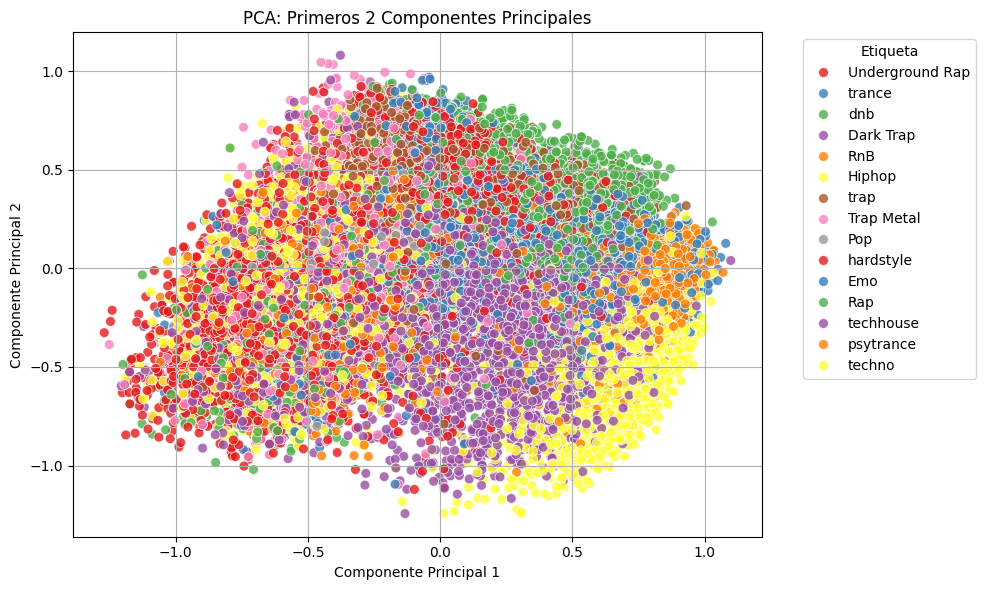

In [17]:
# Seleccionar las dos primeras componentes principales para graficar
pca_df['label'] = y  # Añadir etiquetas al DataFrame de PCA

plt.figure(figsize=(10, 6))

# Usar Seaborn para crear un scatter plot
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='label',  # Colorear según la etiqueta
    palette='Set1',
    s=50,  # Tamaño de los puntos
    alpha=0.8  # Transparencia de los puntos
)

# Añadir etiquetas y título
plt.title("PCA: Primeros 2 Componentes Principales")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title='Etiqueta', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [19]:
# Aplicar PCA (reducir a 3 componentes principales)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_reduced)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
pca_df['Label'] = y  # Añadir las etiquetas (y) para colorear los puntos

# Crear el gráfico 3D interactivo
fig = px.scatter_3d(
    pca_df, 
    x='PC1', 
    y='PC2', 
    z='PC3', 
    color='Label',  # Colorear por etiquetas
    title='Visualización 3D Interactiva de los Componentes Principales',
    labels={'PC1': 'PC1', 'PC2': 'PC2', 'PC3': 'PC3'},
    opacity=0.7,  # Transparencia de los puntos
    width=800,  # Ancho del gráfico
    height=600  # Alto del gráfico
)

# Mostrar el gráfico
fig.show()


Con 3 componentes ya se puede ver cierta agrupación de las clases de los datos

## t-SNE - Feature Extraction

Otra técnica utilizada para la reducción de dimensionalidad es **t-SNE (t-Distributed Stochastic Neighbor Embedding)**. A diferencia de PCA, que busca proyectar los datos de alta dimensión a un espacio de menor dimensión mientras maximiza la varianza, t-SNE se enfoca en **preservar las relaciones de proximidad** entre las muestras. Es particularmente útil cuando se trata de conjuntos de datos no lineales o cuando se desea visualizar patrones y estructuras subyacentes en los datos en dos o tres dimensiones.

t-SNE es una técnica basada en probabilidades que minimiza la divergencia de Kullback-Leibler entre las distribuciones de probabilidad en las dimensiones originales y las dimensiones proyectadas. Esta técnica es ampliamente utilizada en la visualización de datos de alta dimensión, ya que permite observar agrupamientos y relaciones entre las muestras de forma clara y directa.

In [20]:
# Aplicar t-SNE (reducir a 2 dimensiones)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_reduced)

# Crear un DataFrame con los resultados
tsne_df = pd.DataFrame(X_tsne, columns=['Dimension 1', 'Dimension 2'])

# Mostrar el DataFrame resultante
print("Datos transformados con t-SNE (2D):")
print(tsne_df.head())

Datos transformados con t-SNE (2D):
   Dimension 1  Dimension 2
0   -86.022690    30.893723
1    26.269060    18.073940
2  -109.576599    -8.343185
3    66.082886    77.160316
4    11.642362    85.902931


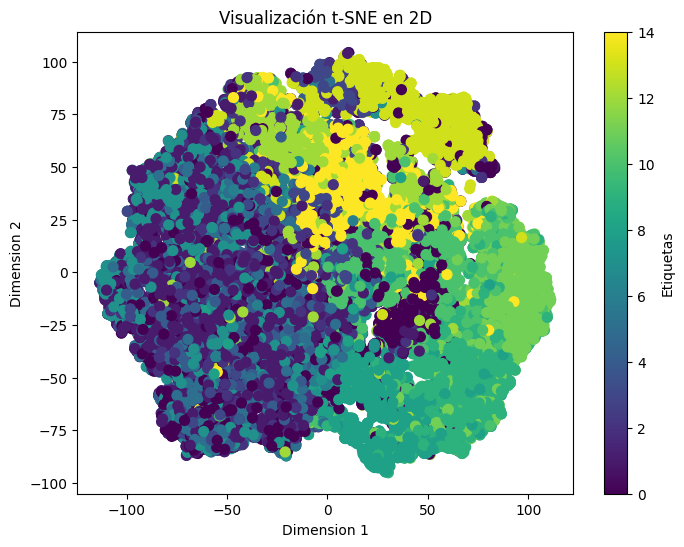

In [21]:
# Graficar los resultados en 2D
plt.figure(figsize=(8, 6))
plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'], c=y_encoded, cmap='viridis', s=50)
plt.title('Visualización t-SNE en 2D')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar(label='Etiquetas')
plt.show()

In [22]:
# Aplicar t-SNE (reducir a 3 dimensiones)
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_reduced)

# Crear un DataFrame con los resultados
tsne_df = pd.DataFrame(X_tsne, columns=['Dimension 1', 'Dimension 2', 'Dimension 3'])

# Mostrar el DataFrame resultante
print("Datos transformados con t-SNE (3D):")
print(tsne_df.head())

Datos transformados con t-SNE (3D):
   Dimension 1  Dimension 2  Dimension 3
0   -26.352547     7.021132   -11.614829
1    14.233404    11.604414     6.528363
2   -25.576891    -5.273388    -9.434785
3     9.412111     6.351447   -30.069271
4    -1.351656    18.599642   -14.189563


In [23]:
import plotly.express as px

# Crear un DataFrame con las etiquetas (y)
tsne_df['Label'] = y_encoded

# Crear el gráfico 3D interactivo
fig = px.scatter_3d(
    tsne_df, 
    x='Dimension 1', 
    y='Dimension 2', 
    z='Dimension 3', 
    color='Label',  # Colorear por etiquetas
    title='Visualización t-SNE en 3D',
    labels={'Dimension 1': 'Dim 1', 'Dimension 2': 'Dim 2', 'Dimension 3': 'Dim 3'},
    opacity=0.7,
    width=800,
    height=600
)

# Mostrar el gráfico
fig.show()

## UMAP - Feature Extraction

**UMAP (Uniform Manifold Approximation and Projection)** es una técnica moderna de reducción de dimensionalidad similar a t-SNE, pero con algunas ventajas, especialmente en términos de **escala y preservación de la estructura global**. UMAP se basa en teorías matemáticas de topología y geometría, buscando mantener las relaciones de proximidad tanto locales como globales en el proceso de reducción. A diferencia de t-SNE, que se enfoca principalmente en preservar la proximidad local, UMAP es más eficiente para capturar y preservar tanto las relaciones cercanas como las más distantes en los datos.

Una de las principales ventajas de UMAP sobre otras técnicas es su capacidad para **manejar grandes volúmenes de datos** de manera más rápida y escalable, al mismo tiempo que preserva estructuras clave que pueden ser útiles para el análisis posterior. Esta técnica es especialmente útil para la visualización de datos de alta dimensión y puede ser una excelente opción cuando se desea explorar la estructura general de los datos sin perder información importante en las relaciones a gran escala.

In [40]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)

# Aplicar UMAP a los datos normalizados
umap_components = umap_reducer.fit_transform(X_reduced)

# Crear un DataFrame con las componentes de UMAP
columns_umap = [f'UMAP-Dim{i+1}' for i in range(umap_components.shape[1])]
umap_df = pd.DataFrame(umap_components, columns=columns_umap)

# Mostrar el DataFrame con las componentes de UMAP
print("DataFrame con las Componentes de UMAP:")
print(umap_df.head())


DataFrame con las Componentes de UMAP:
   UMAP-Dim1  UMAP-Dim2
0  -3.442845   1.507386
1   5.118316   3.672352
2  -3.811466  -1.475489
3   4.173049  10.629930
4   0.338599   6.360286


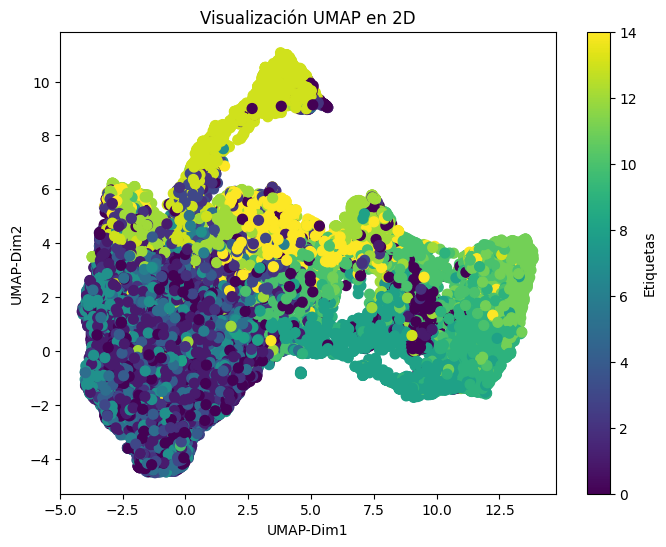

In [25]:
import matplotlib.pyplot as plt

# Graficar los resultados en 2D
plt.figure(figsize=(8, 6))
plt.scatter(umap_df['UMAP-Dim1'], umap_df['UMAP-Dim2'], c=y_encoded, cmap='viridis', s=50)
plt.title('Visualización UMAP en 2D')
plt.xlabel('UMAP-Dim1')
plt.ylabel('UMAP-Dim2')
plt.colorbar(label='Etiquetas')
plt.show()

In [52]:
umap_reducer = umap.UMAP(n_components=3, random_state=42)

# Aplicar UMAP a los datos normalizados
umap_components = umap_reducer.fit_transform(X_reduced)

# Crear un DataFrame con las componentes de UMAP
columns_umap = [f'UMAP-Dim{i+1}' for i in range(umap_components.shape[1])]
umap_df = pd.DataFrame(umap_components, columns=columns_umap)

# Mostrar el DataFrame con las componentes de UMAP
print("DataFrame con las Componentes de UMAP:")
print(umap_df.head())


DataFrame con las Componentes de UMAP:
   UMAP-Dim1  UMAP-Dim2  UMAP-Dim3
0  -2.279664   2.297739   4.529411
1   4.482144   3.213710   7.406986
2  -1.442357   1.243087   3.564973
3   4.116261   7.864432   3.271493
4   0.989712   5.194517   5.559319


In [27]:
import plotly.express as px

# Añadir las etiquetas (y) al DataFrame
umap_df['Label'] = y_encoded

# Crear el gráfico 3D interactivo
fig = px.scatter_3d(
    umap_df, 
    x='UMAP-Dim1', 
    y='UMAP-Dim2', 
    z='UMAP-Dim3', 
    color='Label',  # Colorear por etiquetas
    title='Visualización UMAP en 3D',
    labels={'UMAP-Dim1': 'Dim 1', 'UMAP-Dim2': 'Dim 2', 'UMAP-Dim3': 'Dim 3'},
    opacity=0.7,
    width=800,
    height=600
)

# Mostrar el gráfico
fig.show()

### Reentrenamiento de modelos con Características extraídas con UMAP

In [53]:
# Calcular el cross-validation score - MODELO BASE con UMAP de 3 característica
cv_scores = cross_val_score(rf, umap_df, y_encoded, cv=5, scoring='accuracy')  # 5 particiones, métrica: precisión

# Mostrar los resultados
print("Puntuaciones de validación cruzada:", cv_scores)
print("Precisión media:", cv_scores.mean())
print("Desviación estándar:", cv_scores.std())

Puntuaciones de validación cruzada: [0.55340523 0.54631408 0.54114345 0.54616635 0.544474  ]
Precisión media: 0.5463006197073503
Desviación estándar: 0.004010652565633088


In [49]:
# Declarar e instanciar el modelo SVC
svc = SVC(kernel='linear')  # Puedes cambiar 'linear' por 'rbf' u otro kernel según sea necesario

# Calcular el cross-validation score - MODELO BASE
cv_scores = cross_val_score(svc, umap_df, y_encoded, cv=5, scoring='accuracy')  # 5 particiones, métrica: precisión

# Mostrar los resultados
print("Puntuaciones de validación cruzada:", cv_scores)
print("Precisión media:", cv_scores.mean())
print("Desviación estándar:", cv_scores.std())

Puntuaciones de validación cruzada: [0.48781208 0.49372138 0.48574383 0.48899394 0.49438534]
Precisión media: 0.49013131586180503
Desviación estándar: 0.0033736552100467705


## Conclusiones - Extracción de Características

Tras aplicar las técnicas de extracción de características, se observa que con solo 3 componentes principales se forman ciertos grupos que muestran similitudes con las etiquetas originales. Sin embargo, estos grupos no están claramente separados. A pesar de que se pueden identificar algunas muestras agrupadas por color, no existe una distinción nítida entre los posibles grupos, lo que indica que las características extraídas no han logrado separar las clases de manera óptima. Esto sugiere que, aunque hay patrones potenciales, la separación entre ellos podría necesitar un análisis más profundo o el uso de técnicas adicionales para mejorar la agrupación.


In [54]:
!pip freeze > requirements.txt